Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Hurricane Maria Data

In [2]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/hurricane_maria_2017_train.tsv"
dev_path = "/content/hurricane_maria_2017_dev.tsv"
test_path = "/content/hurricane_maria_2017_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [3]:
train_df

,tweet_id,tweet_text,class_label
0,914134332226330625,San Juan: Trump lashes out with good reason. #...,other_relevant_information
1,910783670134476800,Hurricane Maria Live Updates: Catastrophic Flo...,caution_and_advice
2,912134938727780355,"Getting food to the island is, obviously, crit...",rescue_volunteering_or_donation_effort
3,910669838842056704,My heart breaks for the families in Puerto Ric...,sympathy_and_support
4,912287091026997248,"#B-FAST sending medical, reconstruction &amp; ...",rescue_volunteering_or_donation_effort
...,...,...,...
5831,912462252317560833,RT @TheRickyDavila: An Entire US Territory Is ...,other_relevant_information
5832,913611894426099713,RT @LtGovEvelyn: Hurricane Maria left a trail ...,sympathy_and_support
5833,913034507711807489,"RT @SRuhle: @CCharitiesUSA is providing food, ...",rescue_volunteering_or_donation_effort
5834,913827007758262273,CERT volunteers helped to organize and pack em...,rescue_volunteering_or_donation_effort


In [4]:
test_df

,tweet_id,tweet_text,class_label
0,914370197988896769,On Sept 21 @CarmenYulinCruz San Juan with @FEM...,other_relevant_information
1,911634521593978880,RT @JDEstradawriter: .@CBSThisMorning Limited ...,sympathy_and_support
2,913145214105092096,Photos: #HurricaneMariaRelief effort in Puerto...,other_relevant_information
3,912172452746190849,RT @Skilling: Hurricane Maria destroyed the Na...,infrastructure_and_utility_damage
4,913899614113320960,RT @amphibwarships: .@USNavy amphib @USSWaspLH...,rescue_volunteering_or_donation_effort
...,...,...,...
1437,914248243885699072,"Good lord, its true. Puerto Rico: Teamsters un...",other_relevant_information
1438,911834660669444096,#LITechNews: New Yorkers Pitch In To Help With...,rescue_volunteering_or_donation_effort
1439,912406982199521281,Friendly reminder that this affects 3.5 millio...,requests_or_urgent_needs
1440,914107488194220032,"RT @KJDangerDoll: 70,000 people need the world...",requests_or_urgent_needs


ALL DATA

In [5]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [6]:
tweet_data['class_label'].value_counts()

,count
class_label,
rescue_volunteering_or_donation_effort,1977
other_relevant_information,1568
infrastructure_and_utility_damage,1427
requests_or_urgent_needs,711
sympathy_and_support,672
injured_or_dead_people,302
not_humanitarian,270
caution_and_advice,220
displaced_people_and_evacuations,131


Data Preprocessing

In [7]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [8]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [9]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [11]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

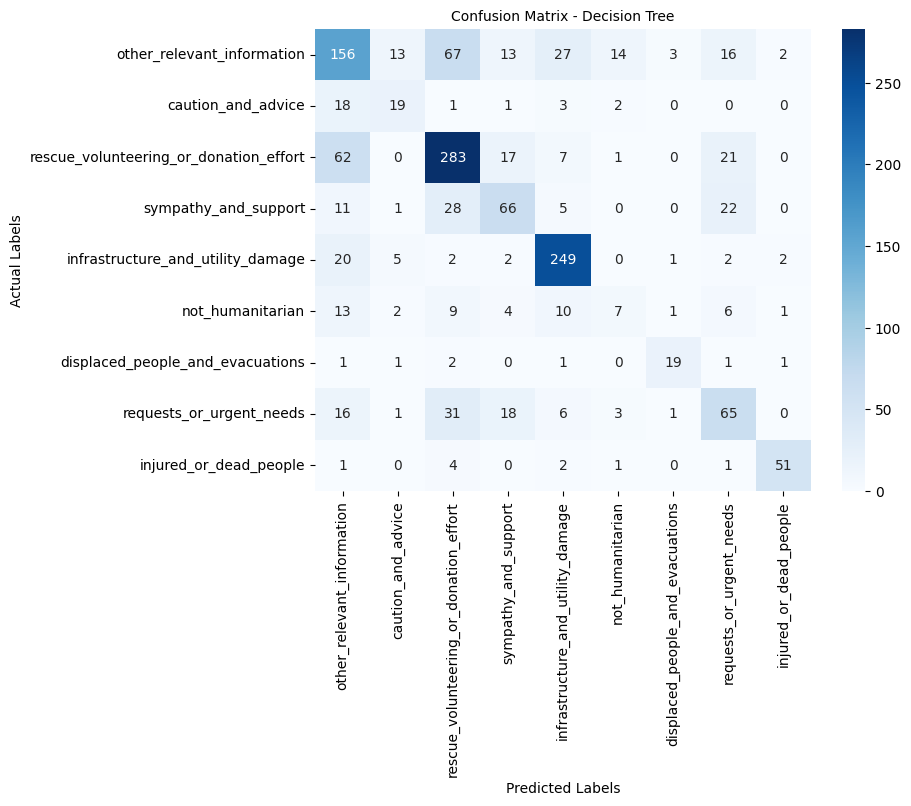


Decision Tree Evaluation:
Accuracy: 0.6345353675450763
Precision: 0.6219131324135906
F1 Score: 0.6266250102060356

 Classification Report:
                                        precision    recall  f1-score   support

            other_relevant_information       0.52      0.50      0.51       311
                    caution_and_advice       0.45      0.43      0.44        44
rescue_volunteering_or_donation_effort       0.66      0.72      0.69       391
                  sympathy_and_support       0.55      0.50      0.52       133
     infrastructure_and_utility_damage       0.80      0.88      0.84       283
                      not_humanitarian       0.25      0.13      0.17        53
      displaced_people_and_evacuations       0.76      0.73      0.75        26
              requests_or_urgent_needs       0.49      0.46      0.47       141
                injured_or_dead_people       0.89      0.85      0.87        60

                              accuracy                    

In [12]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

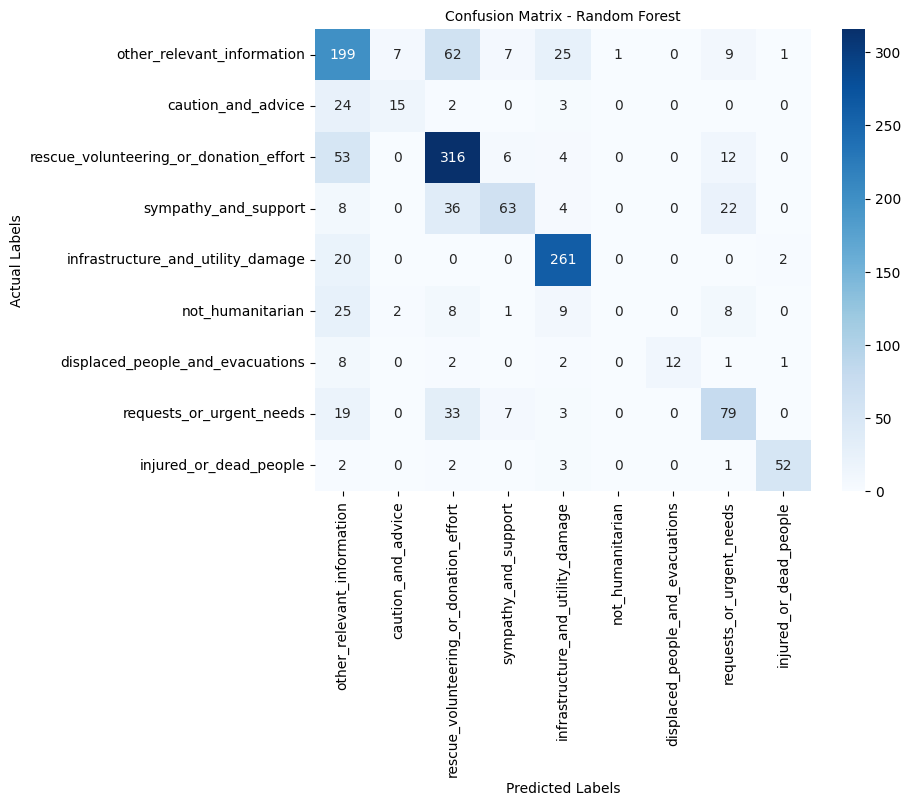


Random Forest Evaluation:
Accuracy: 0.6914008321775312
Precision: 0.6723126135105658
F1 Score: 0.6733428222580708

 Classification Report:
                                        precision    recall  f1-score   support

            other_relevant_information       0.56      0.64      0.59       311
                    caution_and_advice       0.62      0.34      0.44        44
rescue_volunteering_or_donation_effort       0.69      0.81      0.74       391
                  sympathy_and_support       0.75      0.47      0.58       133
     infrastructure_and_utility_damage       0.83      0.92      0.87       283
                      not_humanitarian       0.00      0.00      0.00        53
      displaced_people_and_evacuations       1.00      0.46      0.63        26
              requests_or_urgent_needs       0.60      0.56      0.58       141
                injured_or_dead_people       0.93      0.87      0.90        60

                              accuracy                    

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

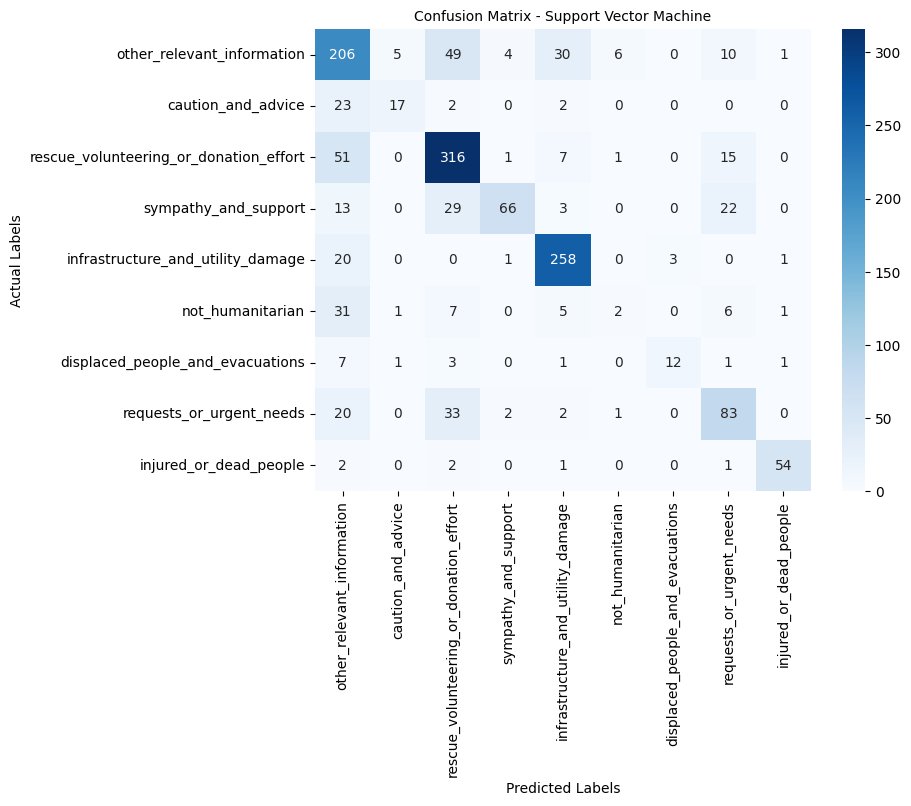


Support Vector Machine Evaluation:
Accuracy: 0.7031900138696255
Precision: 0.7004694978872754
F1 Score: 0.6901594540931476

 Classification Report:
                                        precision    recall  f1-score   support

            other_relevant_information       0.55      0.66      0.60       311
                    caution_and_advice       0.71      0.39      0.50        44
rescue_volunteering_or_donation_effort       0.72      0.81      0.76       391
                  sympathy_and_support       0.89      0.50      0.64       133
     infrastructure_and_utility_damage       0.83      0.91      0.87       283
                      not_humanitarian       0.20      0.04      0.06        53
      displaced_people_and_evacuations       0.80      0.46      0.59        26
              requests_or_urgent_needs       0.60      0.59      0.59       141
                injured_or_dead_people       0.93      0.90      0.92        60

                              accuracy           

In [14]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")